In [1]:
import torch
from torch import nn
import torch.nn.functional as F
from utils import View
from utils import train_network
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets
from torchvision.datasets import MNIST
from torchvision import transforms
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

d:\projects\git-hub\simple-nonlinear-PCA\utils.py:7: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


In [2]:
D=28*28               # Dimension of the input data
n=2                   # no of hidden layers
C=1                   # no of channels
classes=10            # output classes

In [7]:
class AutoEncodeDataset(Dataset):
    """Takes a dataset with (x, y) label pairs and converts it to (x, x) pairs. 
    This makes it easy to re-use other code"""

    def __init__(self, dataset):
        self.dataset = dataset

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        x, y = self.dataset.__getitem__(idx)
        return x, x # just throw away the original label.

In [14]:
train_data = AutoEncodeDataset(MNIST("./", train=True, transform=transforms.ToTensor(), download=True))
test_data_xy = MNIST("./", train=False, transform=transforms.ToTensor(), download=True)
test_data_xx = AutoEncodeDataset(test_data_xy)

train_loader = DataLoader(train_data, batch_size=128, shuffle=True)
test_loader = DataLoader(test_data_xx, batch_size=128)

In [15]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [16]:
'''
intiate the sequence with flattening the 28*28 img then passing that into linear
with size 28*28 = 784 and output size n = 2
'''
PCA_non_linear_encoder = nn.Sequential(
    nn.Flatten(),
    nn.Linear(D,n),
    nn.Tanh(),
)
'''
intiate the sequence with taking the features of n = 2 thatw ended with into
784 afain using a Linear layer (n,D) then changing the view of these using a internal 
utils function like View or using UnFlatten from torch.nn
'''

PCA_non_linear_decoder = nn.Sequential(
    nn.Linear(n,D),
    View(-1,1,28,28),
)

'''
making the encoder decoder sequential model
'''
PCA_non_linear = nn.Sequential(
    PCA_non_linear_encoder,
    PCA_non_linear_decoder
)

In [18]:
train_network(PCA_non_linear,loss_func=nn.MSELoss(),
            train_loader=train_loader,test_loader=test_loader,epochs=6,device=device)

Epoch: 100%|██████████| 6/6 [00:49<00:00,  8.33s/it]


,epoch,total time,train loss,test loss
0,0,7.796496,0.064559,0.063646
1,1,14.983191,0.062485,0.061586
2,2,21.995445,0.060499,0.059650
3,3,29.015242,0.058718,0.058229
4,4,36.167465,0.057645,0.057477
5,5,43.221866,0.057147,0.057155


In [21]:
def encode_batch(encoder,dataset_to_encode):
    """
    encoder: the PyTorch network that takes in a dataset and convers it to a new dimension
    dataset_to_encode: a PyTorch `Dataset` object that we want to convert. 

    Returns a tuple (projected, labels) where `projected` is the encoded version of the dataset,
    and `labels` are the original labels provided by the `dataset_to_encode`
    """
    projected = []
    labels = []

    encoder = encoder.eval()
    encoder = encoder.cpu() # move to the CPU , not mandatory
    with torch.inference_mode():
        for x, y in DataLoader(dataset_to_encode,batch_size=128):
            z = encoder(x.cpu())
            projected.append(z.numpy())
            labels.append(y.cpu().numpy().ravel())
    projected = np.vstack(projected)
    labels = np.hstack(labels)

    return projected, labels

In [22]:
projected , labels = encode_batch(PCA_non_linear_encoder,test_data_xy)

<Axes: >

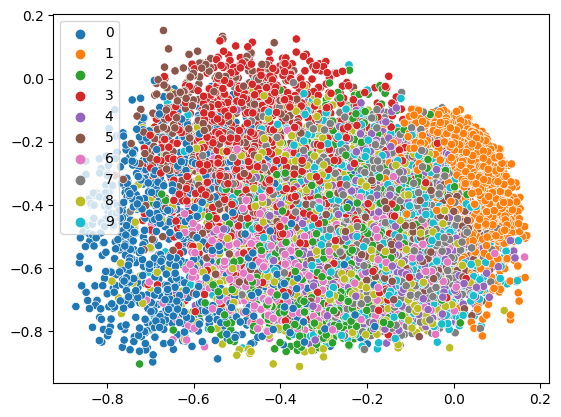

In [26]:
sns.scatterplot(x=projected[:,0],
                y=projected[:,1],
                hue=[str(l) for l in labels],
                hue_order=[str(i) for i in range(10)],
                legend="full")

In [30]:
def show_encode_decode(encode_decode,x):
    """
    encode_decode: the PyTorch Module that does the encoding and decoding steps at once
    x: the input to plot as is, and after encoding & decoding it
    """
    encode_decode = encode_decode.eval()
    encode_decode = encode_decode.cpu()
    with torch.inference_mode():
        x_recon = encode_decode(x.cpu())
        f , axarr = plt.subplots(1,2)
    axarr[0].imshow(x.numpy()[0,:])
    axarr[1].imshow(x_recon.numpy()[0,0,:])

In [ ]:
show_encode_decode(PCA_non_linear,test_data_xy[0][0])
show_encode_decode(PCA_non_linear,test_data_xy[1][0])
show_encode_decode(PCA_non_linear,test_data_xy[3][0])